# 005\_knn\_benchmark – KNN 推荐系统性能评估实验  
**KNN Visual Recommender Benchmark – Speed · Similarity · Scalability**

本 notebook 用于在现有的 `FashionRecommender`（KNN 模型）上：  
This notebook benchmarks the existing `FashionRecommender` (KNN model) on:

1. **平均 Top-5 查询时间**（推荐速度 / speed）  
2. **平均 Top-5 相似度**（推荐质量 / recommendation similarity）  
3. **随 gallery 规模变化的查询时间**（可扩展性 / scalability）  

> ⚠️ 请在与你的项目同一目录下运行本 notebook，并确保：  
> Please run this notebook in the same project directory and make sure that:
> - `src/recommender.py` 存在，且可以成功导入 `FashionRecommender`  
> - `Index/features.npy` 和 `Index/keys.csv` 已经由你之前的建模流程生成  


In [43]:
# ===============================================================
# Step 0: Import & Load KNN Recommender / 导入并加载 KNN 推荐器
# ===============================================================

from pathlib import Path
import time
import numpy as np
import pandas as pd

from src.recommender import FashionRecommender  # 确保路径正确 / ensure path is correct

# 设置 Index 目录（与你 Streamlit 一致）
# Set index directory (same as in your Streamlit app)
INDEX_DIR = Path("./Index")

rec = FashionRecommender(index_dir=INDEX_DIR, verbose=True)

# 查看基本信息 / Quick sanity check
print("Total rows in keys:", len(rec.keys))
print("Gallery candidates:", len(rec.gallery_indices))
print("Unique products:", len(rec.products))

[FashionRecommender] Loaded 26830 rows, 12612 gallery candidates, 3985 unique products.
Total rows in keys: 26830
Gallery candidates: 12612
Unique products: 3985


In [44]:
# ===============================================================
# Step 1: Prepare query set & full gallery indices
#         准备全量 query 集合和完整 gallery 索引
# ===============================================================

keys_df = rec.keys.copy()

# 1. 全量 query 集合（用于所有实验）
#    Full query set (we will use all queries for benchmarking)
query_mask = keys_df["eval_split"].astype(str).str.lower() == "query"
query_ids = keys_df.loc[query_mask, "product_id"].astype(str).unique()
print("Number of unique query products:", len(query_ids))

# 2. 完整 gallery 索引（in_stock == 1 且 eval_split == 'gallery'）
#    Full gallery indices (as defined in FashionRecommender)
full_gallery_idx = rec.gallery_indices.copy()
print("Number of gallery candidates:", len(full_gallery_idx))

Number of unique query products: 3985
Number of gallery candidates: 12612


In [45]:
# ===============================================================
# Step 2: Define gallery sizes for scalability experiment
#         为可扩展性实验定义多个 gallery 规模
# ===============================================================

# 你可以根据需要调整这些点，例如 [3000, 6000, len(full_gallery_idx)]
# You can adjust these sizes if needed
target_sizes = [3000, 6000, len(full_gallery_idx)]

# 使用固定随机种子，保证 KNN 和 ANN 共享同一批子集
# Use a fixed random seed so KNN and ANN share the same subsets
rng = np.random.default_rng(42)
gallery_subsets = {}

for size in target_sizes:
    size = min(size, len(full_gallery_idx))
    subset = rng.choice(full_gallery_idx, size=size, replace=False)
    gallery_subsets[size] = subset

print("Gallery subset sizes:", list(gallery_subsets.keys()))
import numpy as np

np.save("gallery_subsets_knn.npy", gallery_subsets)
print("Saved KNN gallery subsets to gallery_subsets_knn.npy")


Gallery subset sizes: [3000, 6000, 12612]
Saved KNN gallery subsets to gallery_subsets_knn.npy


In [46]:
# ===============================================================
# Step 3: Define KNN benchmark function
#         定义 KNN 性能评估函数
# ===============================================================

def benchmark_knn_for_gallery(
    knn_rec: FashionRecommender,
    query_ids,
    gallery_indices_subset,
    top_k: int = 5,
    filter_category: bool = True,
    filter_in_stock: bool = False,
):
    """
    在给定的 gallery 子集上评估 KNN 推荐器：
    Benchmark the KNN recommender on a given gallery subset:

    - 平均 Top-5 查询时间（秒）
      Average Top-5 query time (seconds)
    - 平均 Top-5 相似度
      Average Top-5 similarity

    参数 / Args:
        knn_rec: 已初始化的 FashionRecommender 实例
                 initialized FashionRecommender instance
        query_ids: 用于评估的 product_id 列表（建议使用全量 query）
                   list/array of product_ids to evaluate (e.g., full query set)
        gallery_indices_subset: 当前 gallery 子集在 keys 中的行索引
                                numpy array of row indices representing the gallery subset
        top_k: 推荐的 Top-K 数量（默认 5）
               number of recommendations (Top-K), default 5
        filter_category: 是否限制推荐在相同类目中（与 app 保持一致）
                         whether to restrict recommendations to same category
        filter_in_stock: 是否过滤只保留 in_stock==1（一般 gallery 已经保证）
                         whether to filter in_stock==1 only (usually already enforced)

    返回 / Returns:
        dict with:
          - n_queries: 使用的 query 数量
          - avg_time: 平均查询时间（秒）
          - std_time: 查询时间标准差
          - avg_similarity: 平均相似度（如果有）
          - n_recs: 收集到的推荐条目总数
    """
    # 1. 在当前 gallery 子集上重建 KNN 索引
    #    Rebuild KNN index on this specific gallery subset
    knn_rec.gallery_indices = np.array(gallery_indices_subset)
    gallery_features = knn_rec.features[knn_rec.gallery_indices]
    knn_rec.knn.fit(gallery_features)

    times = []
    all_sims = []

    for pid in query_ids:
        pid_str = str(pid)

        t0 = time.perf_counter()
        recs = knn_rec.recommend_similar_products(
            product_id=pid_str,
            top_k=top_k,
            filter_category=filter_category,
            filter_in_stock=filter_in_stock,
            return_similarity=True,
        )
        t1 = time.perf_counter()

        times.append(t1 - t0)

        # 收集相似度 / Collect similarity scores
        if recs is not None and not recs.empty and "similarity" in recs.columns:
            all_sims.extend(recs["similarity"].tolist())

    times = np.array(times, dtype=float)
    all_sims = np.array(all_sims, dtype=float) if len(all_sims) > 0 else np.array([])

    result = {
        "n_queries": int(len(query_ids)),
        "avg_time": float(times.mean()),
        "std_time": float(times.std()),
        "avg_similarity": float(all_sims.mean()) if len(all_sims) > 0 else None,
        "n_recs": int(len(all_sims)),
    }
    return result

In [47]:
# ===============================================================
# Step 4: Run KNN benchmark for different gallery sizes
#         在不同 gallery 规模下运行 KNN 基准实验
# ===============================================================

knn_results = {}

for size, subset_idx in gallery_subsets.items():
    print(f"=== KNN benchmark: gallery size = {size} ===")
    res = benchmark_knn_for_gallery(
        knn_rec=rec,
        query_ids=query_ids,
        gallery_indices_subset=subset_idx,
        top_k=5,
        filter_category=True,   # 与 app 保持一致 / keep consistent with app
        filter_in_stock=False,
    )
    knn_results[size] = res
    print(res)

knn_results

=== KNN benchmark: gallery size = 3000 ===
{'n_queries': 3985, 'avg_time': 0.0659751954326103, 'std_time': 0.02698161699091092, 'avg_similarity': 0.799910179339209, 'n_recs': 19925}
=== KNN benchmark: gallery size = 6000 ===
{'n_queries': 3985, 'avg_time': 0.1343628267503365, 'std_time': 0.0332027277752447, 'avg_similarity': 0.8129089950258789, 'n_recs': 19925}
=== KNN benchmark: gallery size = 12612 ===
{'n_queries': 3985, 'avg_time': 0.25299800107891113, 'std_time': 0.050273208877710404, 'avg_similarity': 0.8247458500963831, 'n_recs': 19925}


{3000: {'n_queries': 3985,
  'avg_time': 0.0659751954326103,
  'std_time': 0.02698161699091092,
  'avg_similarity': 0.799910179339209,
  'n_recs': 19925},
 6000: {'n_queries': 3985,
  'avg_time': 0.1343628267503365,
  'std_time': 0.0332027277752447,
  'avg_similarity': 0.8129089950258789,
  'n_recs': 19925},
 12612: {'n_queries': 3985,
  'avg_time': 0.25299800107891113,
  'std_time': 0.050273208877710404,
  'avg_similarity': 0.8247458500963831,
  'n_recs': 19925}}

In [48]:
# ===============================================================
# Step 5: Convert results to DataFrame & (optionally) save
#         将结果整理为 DataFrame，并（可选）保存为 CSV
# ===============================================================

knn_results_df = pd.DataFrame.from_dict(knn_results, orient="index")
knn_results_df.index.name = "gallery_size"
knn_results_df = knn_results_df.reset_index()

print("KNN benchmark results:")
display(knn_results_df)

# 可选：保存结果到 CSV，方便画图或在报告中使用
# Optional: save to CSV for plotting or reporting
out_path = Path("./knn_benchmark_results.csv")
knn_results_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"Saved KNN benchmark results to: {out_path.resolve()}")

KNN benchmark results:


,gallery_size,n_queries,avg_time,std_time,avg_similarity,n_recs
0,3000,3985,0.065975,0.026982,0.799910,19925
1,6000,3985,0.134363,0.033203,0.812909,19925
2,12612,3985,0.252998,0.050273,0.824746,19925


Saved KNN benchmark results to: D:\Icey\tcd\notebooks\dMining\Group Project\workflow\fashion_recommender_knn\knn_benchmark_results.csv


C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26597 (\N{CJK UNIFIED IDEOGRAPH-67E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35810 (\N{CJK UNIFIED IDEOGRAPH-8BE2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170:

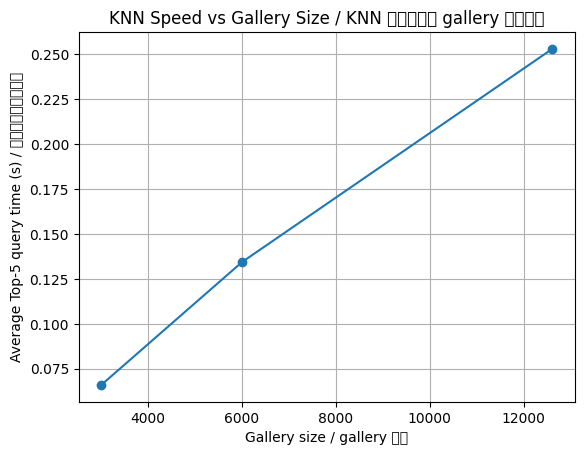

C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Icey\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20284 (\N{CJK UNIFIED IDEOGRAPH-4F3C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


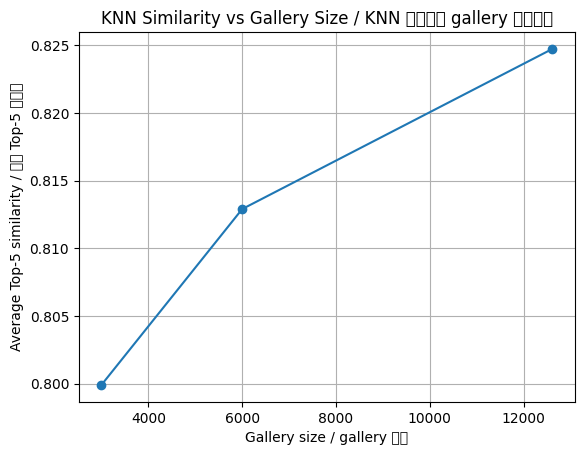

In [49]:
# ===============================================================
# Step 6: (Optional) Quick visualization
#         （可选）简单画图查看速度 & 相似度趋势
# ===============================================================

import matplotlib.pyplot as plt

# 速度 vs gallery 规模 / Speed vs gallery size
plt.figure()
plt.plot(knn_results_df["gallery_size"], knn_results_df["avg_time"], marker="o")
plt.xlabel("Gallery size / gallery 规模")
plt.ylabel("Average Top-5 query time (s) / 平均查询时间（秒）")
plt.title("KNN Speed vs Gallery Size / KNN 查询速度随 gallery 规模变化")
plt.grid(True)
plt.show()

# 相似度 vs gallery 规模 / Similarity vs gallery size (if available)
if knn_results_df["avg_similarity"].notna().any():
    plt.figure()
    plt.plot(knn_results_df["gallery_size"], knn_results_df["avg_similarity"], marker="o")
    plt.xlabel("Gallery size / gallery 规模")
    plt.ylabel("Average Top-5 similarity / 平均 Top-5 相似度")
    plt.title("KNN Similarity vs Gallery Size / KNN 相似度随 gallery 规模变化")
    plt.grid(True)
    plt.show()